In [21]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from spec_id import *
from sim_engine import *
from spec_stats import Highest_density_region
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared
from C_sim_test import Gen_sim, F_lam_per_M
from prospect.models.transforms import logsfr_ratios_to_masses

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

# Examine fits

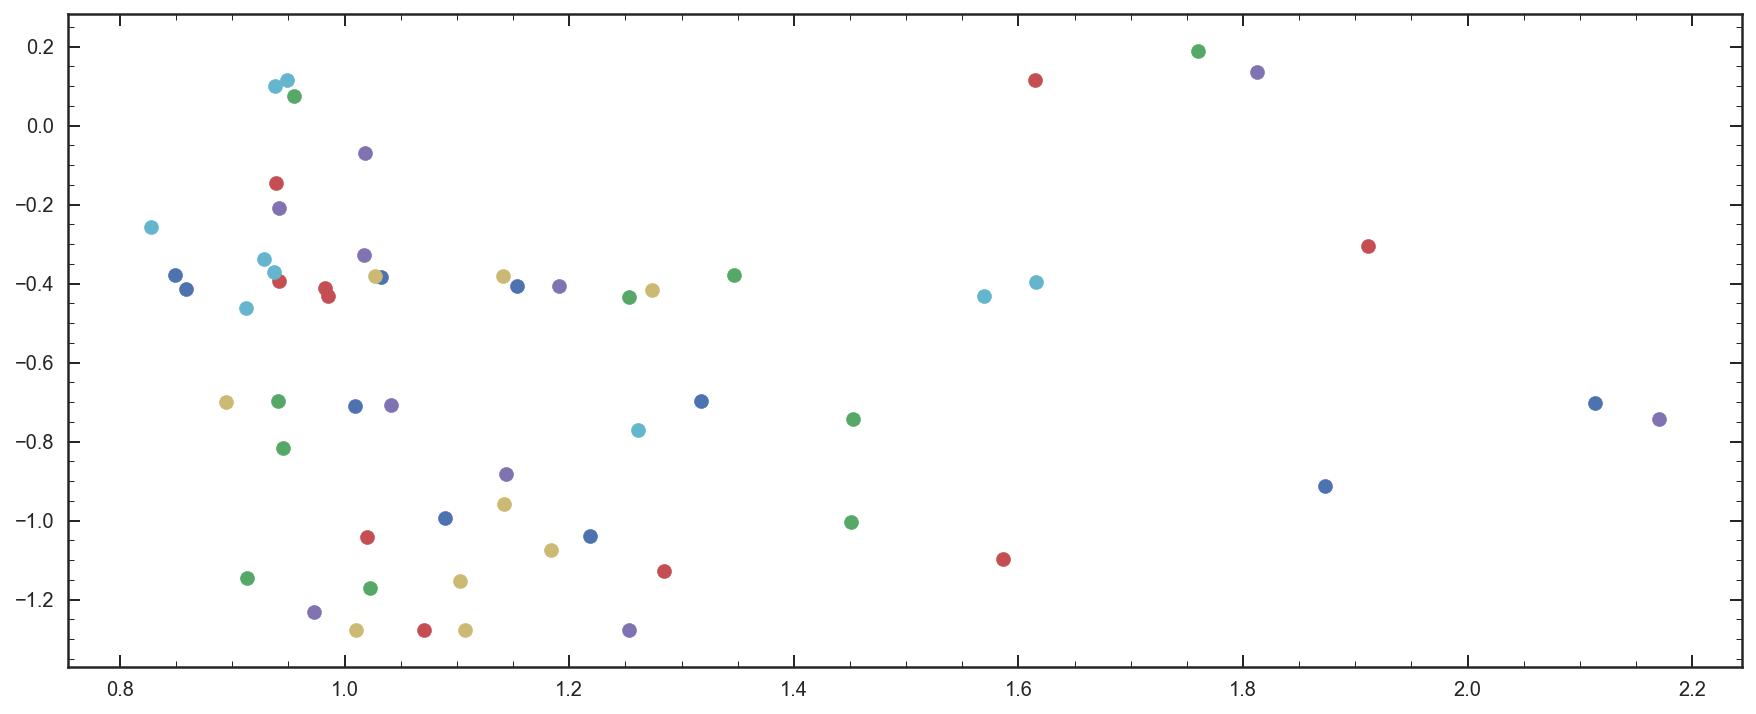

In [20]:
flist = glob('../data/posteriors/G*tabfit_Pm.*')
zlist = glob('../data/posteriors/G*tabfit_Pz.*')

plt.figure(figsize=[15,6])
for i in range(len(flist)):
    x,px = np.load(flist[i])
    z,pz = np.load(zlist[i])
    plt.scatter(z[pz == max(pz)],np.log10(x[px == max(px)]))
    
# plt.scatter([1,1.25,1.75],[3.1,2.5,2], color='k')
# plt.ylim(0,7)
# # plt.xlim(.1,2)

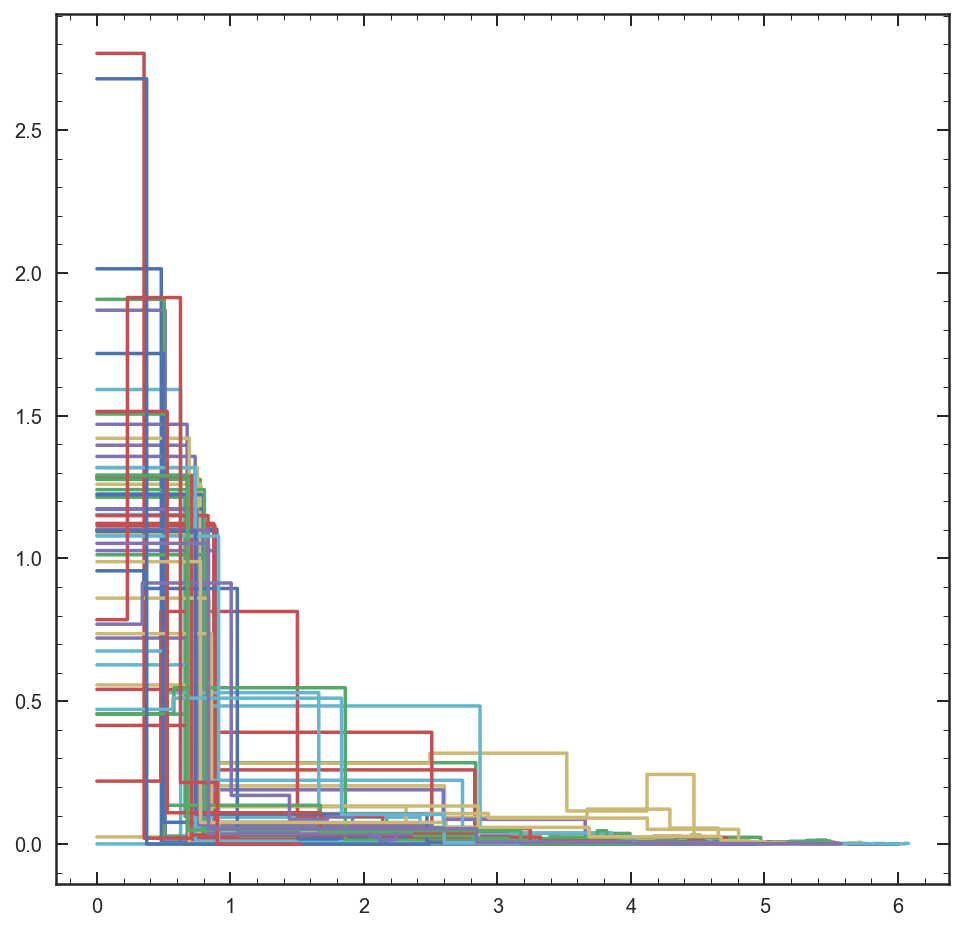

In [27]:
flist = glob('../data/bestfits/G*_tabfit_bfit.npy')

plt.figure(figsize = [8,8])

for i in flist:
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(i)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    plt.plot(time,sfr)
